In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import pandas as pd

matplotlib.style.use('ggplot')

## Simple linear regression

We are using the following model
$$ Y = a + b x + \epsilon$$
where $\epsilon$ is a random variable with zero mean and variance $\sigma^2$.

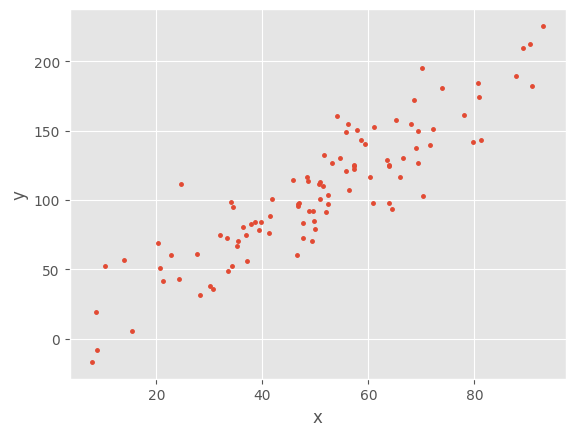

In [19]:
# Generate some sample data

# The true model is y = 2x + 5
x_obs = np.random.normal(50, 20, 100)
y_obs = 2*x_obs + 5 + np.random.normal(0, 20, 100)

# Plot the data
plt.plot(x_obs, y_obs, '.', markersize=5)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

The parameters $a$ and $b$ are estimated by minimizing the sum of squared errors. The results are
$$ b = \frac{\sum_{i=1}^n x_i y_i - \frac{1}{n} \sum_{i=1}^n x_i \sum_{i=1}^n y_i}{\sum_{i=1}^n x_i^2 - \frac{1}{n} \left(\sum_{i=1}^n x_i\right)^2}$$
and
$$ a = \frac{1}{n} \sum_{i=1}^n y_i - b \frac{1}{n} \sum_{i=1}^n x_i.$$

Slope:  2.1656066102284717
Intercept:  -3.3817938613018015


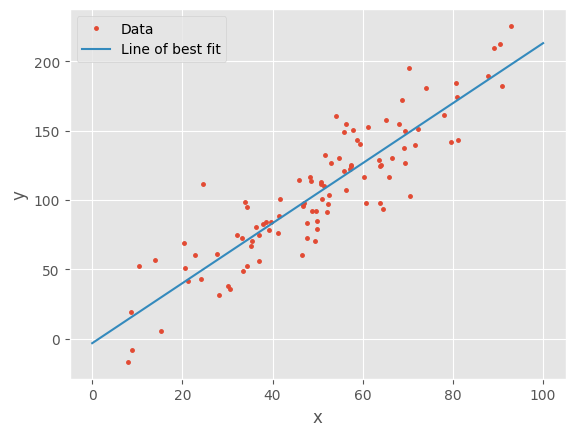

In [20]:
# Calculate the slope and intercept of the line of best fit
b = (np.sum(x_obs*y_obs) - np.sum(x_obs) * np.sum(y_obs) / len(x_obs)) / (np.sum(x_obs**2) - np.sum(x_obs)**2 / len(x_obs))
a = np.mean(y_obs) - b * np.mean(x_obs)

print('Slope: ', b)
print('Intercept: ', a)

# Plot the line of best fit
plt.plot(x_obs, y_obs, '.', markersize=5, label='Data')
plt.plot(np.linspace(0, 100, 1000), a + b * np.linspace(0, 100, 1000), label='Line of best fit')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

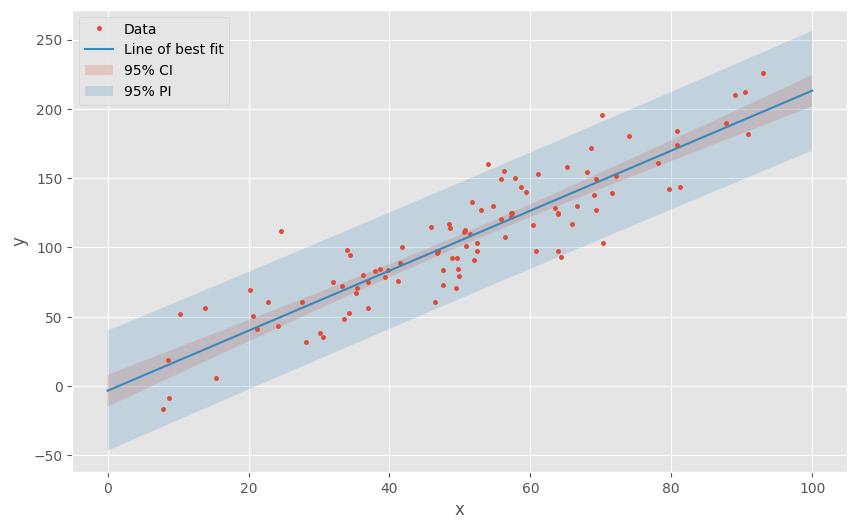

In [21]:
# Let's add confidence intervals to the line of best fit
from scipy.stats import t

dof = len(x_obs) - 2
x_mean = np.mean(x_obs)
n = len(x_obs)
y_pred = a + b * x_obs
s = np.sqrt(np.sum((y_obs - y_pred)**2) / dof)
Sxx = np.sum((x_obs - x_mean)**2)
# 95% confidence interval two sided
t_crit = t.ppf(0.975, dof)


y_lower = y_pred - t_crit * s * np.sqrt(1/n + (x_obs - x_mean)**2 / Sxx)
y_upper = y_pred + t_crit * s * np.sqrt(1/n + (x_obs - x_mean)**2 / Sxx)

# Plot the line of best fit
xs = np.linspace(0, 100, 1000)
ys = a + b * xs
mus_upper = ys + t_crit * s * np.sqrt(1/n + (xs - x_mean)**2 / Sxx)
mus_lower = ys - t_crit * s * np.sqrt(1/n + (xs - x_mean)**2 / Sxx)

ys_upper = ys + t_crit * s * np.sqrt(1 + 1/n + (xs - x_mean)**2 / Sxx)
ys_lower = ys - t_crit * s * np.sqrt(1 + 1/n + (xs - x_mean)**2 / Sxx)


fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(x_obs, y_obs, '.', markersize=5, label='Data')
plt.plot(xs, ys, label='Line of best fit')
plt.fill_between(xs, mus_lower, mus_upper, alpha=0.2, label=r'95% CI')
plt.fill_between(xs, ys_lower, ys_upper, alpha=0.2, label=r'95% PI')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [22]:
# Let's create a linear regression class
from scipy.stats import t, f

class LinearRegression:
    def __init__(self, intercept=True) -> None:
        self.X = None
        self.y = None
        self.beta = None
        self.residuals = None
        self.sigma2 = None
        self.beta_vars = None
        self.beta_tscores = None
        self.beta_probability = None
        self.intercept = intercept
        
    def fit(self, X, y):
        if self.intercept:
            X = np.hstack([np.ones((len(X), 1)), X])
        self.X = X
        self.y = y
        design_matrix = X.T @ X
        inverse_design = np.linalg.inv(design_matrix)
        self.design_matrix = design_matrix
        self.inverse_design = inverse_design
        self.beta = inverse_design @ X.T @ y
        self.residuals = y - X @ self.beta
        self.sigma2 = np.sum(self.residuals**2) / (len(y) - X.shape[1] - 1)
        self.beta_vars = inverse_design * self.sigma2
        self.beta_tscores = self.beta / np.sqrt(np.diag(self.beta_vars).flatten())
        self.beta_probability = 2 * (1 - t.cdf(np.abs(self.beta_tscores), len(y) - X.shape[1] - 1))
        
    def predict(self, X, confidence_interval=False, prediction_interval=False):
        if self.intercept:
            X = np.hstack([np.ones((len(X), 1)), X])
        y_pred = X @ self.beta
        if confidence_interval and prediction_interval:
            dof = len(self.y) - X.shape[1] - 1
            s = np.sqrt(self.sigma2)
            t_crit = t.ppf(confidence_interval + (1 - confidence_interval) / 2, dof)
            ci = t_crit * s * np.sqrt(X @ self.inverse_design @ X.T)
            pi = t_crit * s * np.sqrt(1 + X @ self.inverse_design @ X.T)
            return y_pred, np.diag(ci).flatten(), np.diag(pi).flatten()
        elif confidence_interval:
            dof = len(self.y) - X.shape[1]
            s = np.sqrt(self.sigma2)
            t_crit = t.ppf(confidence_interval + (1 - confidence_interval) / 2, dof)
            x_mean = np.mean(self.X[:,1:], axis=0)
            Sxx = np.sum((self.X[:,1:] - x_mean)**2, axis=0)
            ci = t_crit * s * np.sqrt(1/len(self.y) + (X[:,1:] - x_mean)**2 / Sxx)
            return y_pred, ci
        elif prediction_interval:
            dof = len(self.y) - X.shape[1]
            s = np.sqrt(self.sigma2)
            t_crit = t.ppf(confidence_interval + (1 - confidence_interval) / 2, dof)
            x_mean = np.mean(self.X[:,1:], axis=0)
            Sxx = np.sum((self.X[:,1:] - x_mean)**2, axis=0)
            pi = t_crit * s * np.sqrt(1 + 1/len(self.y) + (X[:,1:] - x_mean)**2 / Sxx)
            return y_pred, pi
        return y_pred
    
    def summary(self):
        print('Linear Regression Summary')
        print('==========================')
        print(f'Number of observations: {len(self.y)}')
        print(f'Number of predictors: {self.X.shape[1]}')
        print(f'Sigma^2: {self.sigma2:.4f}')
        r2 = 1 - np.sum(self.residuals**2) / np.sum((self.y - np.mean(self.y))**2)
        print(f'R^2: {r2:.4f}')
        print(f'Adjusted R^2: {1 - (1 - r2) * (len(self.y) - 1) / (len(self.y) - self.X.shape[1] - 1):.4f}')
        print(f'F-statistic: {(np.sum(self.residuals**2) / (self.X.shape[1] - 1)) / self.sigma2:.4f}')
        print(f'p-value: {1 - f.cdf((np.sum(self.residuals**2) / (self.X.shape[1] - 1)) / self.sigma2, self.X.shape[1] - 1, len(self.y) - self.X.shape[1] - 1):.4f}')
        print("====================================")
        print('Coefficients')
        for i, beta in enumerate(self.beta):
            print(f'beta_{i}: {beta:.4f}')
            print(f't-score: {self.beta_tscores[i]:.4f}')
            print(f'p-value: {self.beta_probability[i]:.4f}')
            print()
        
# Let's test it out
X = x_obs.reshape(-1, 1)
y = y_obs
lr = LinearRegression()
lr.fit(X, y)
lr.summary()

Linear Regression Summary
Number of observations: 100
Number of predictors: 2
Sigma^2: 447.2537
R^2: 0.8061
Adjusted R^2: 0.8021
F-statistic: 97.0000
p-value: 0.0000
Coefficients
beta_0: -3.3818
t-score: -0.5788
p-value: 0.5640

beta_1: 2.1656
t-score: 20.0800
p-value: 0.0000



C:\Users\matej\AppData\Local\Temp\ipykernel_16844\2010042896.py:40: RuntimeWarning: invalid value encountered in sqrt
  ci = t_crit * s * np.sqrt(X @ self.inverse_design @ X.T)


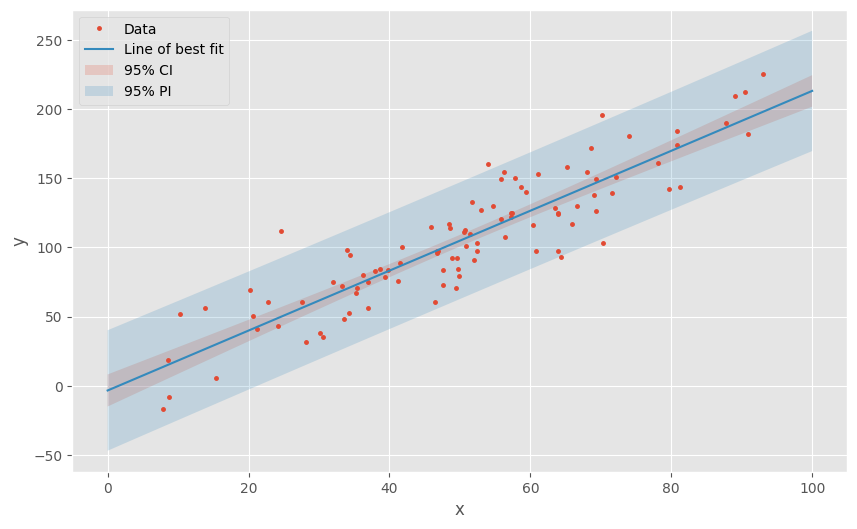

In [23]:
xs = np.linspace(0, 100, 1000).reshape(-1, 1)
ys, ci, pi = lr.predict(xs, confidence_interval=0.95, prediction_interval=0.95)

fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(x_obs, y_obs, '.', markersize=5, label='Data')
plt.plot(xs, ys, label='Line of best fit')
plt.fill_between(xs.flatten(), ys-ci, ys+ci, alpha=0.2, label=r'95% CI')
plt.fill_between(xs.flatten(), ys-pi, ys+pi, alpha=0.2, label=r'95% PI')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

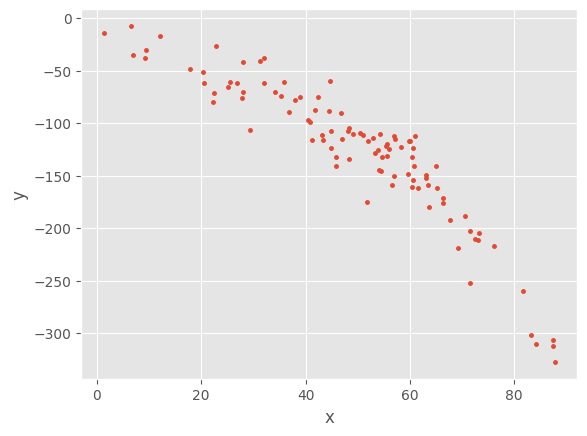

In [24]:
# More complicated example of linear regression

# The true model is y = -1/1000*x^3 + 1/10*x^2 - 5*x + 10
x_obs = np.random.normal(50, 20, 100)
y_obs = -1/1000*x_obs**3 + 1/10*x_obs**2 - 5*x_obs + 10 + np.random.normal(0, 20, 100)

# Plot the data
plt.plot(x_obs, y_obs, '.', markersize=5)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [25]:
X = np.hstack([x_obs.reshape(-1, 1), (x_obs**2).reshape(-1, 1), (x_obs**3).reshape(-1, 1)])
y = y_obs
lr = LinearRegression()
lr.fit(X, y)
lr.summary()

Linear Regression Summary
Number of observations: 100
Number of predictors: 4
Sigma^2: 344.0809
R^2: 0.9273
Adjusted R^2: 0.9242
F-statistic: 31.6667
p-value: 0.0000
Coefficients
beta_0: -3.2844
t-score: -0.2718
p-value: 0.7864

beta_1: -3.2890
t-score: -3.3818
p-value: 0.0010

beta_2: 0.0566
t-score: 2.4554
p-value: 0.0159

beta_3: -0.0007
t-score: -4.2647
p-value: 0.0000



C:\Users\matej\AppData\Local\Temp\ipykernel_16844\2010042896.py:40: RuntimeWarning: invalid value encountered in sqrt
  ci = t_crit * s * np.sqrt(X @ self.inverse_design @ X.T)
C:\Users\matej\AppData\Local\Temp\ipykernel_16844\2010042896.py:41: RuntimeWarning: invalid value encountered in sqrt
  pi = t_crit * s * np.sqrt(1 + X @ self.inverse_design @ X.T)


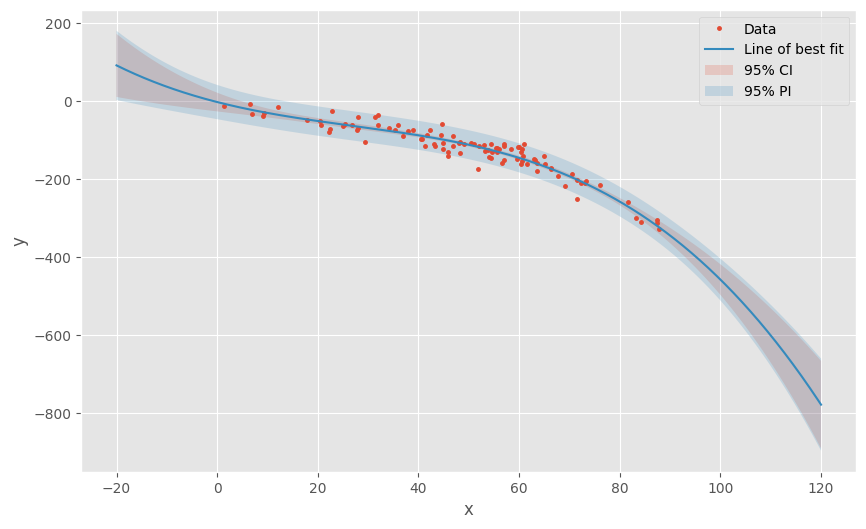

In [26]:
xs = np.linspace(-20, 120, 1000).reshape(-1, 1)
ys, ci, pi = lr.predict(np.hstack([xs, xs**2, xs**3]), confidence_interval=0.95, prediction_interval=0.95)

fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(x_obs, y_obs, '.', markersize=5, label='Data')
plt.plot(xs, ys, label='Line of best fit')
plt.fill_between(xs.flatten(), ys-ci, ys+ci, alpha=0.2, label=r'95% CI')
plt.fill_between(xs.flatten(), ys-pi, ys+pi, alpha=0.2, label=r'95% PI')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [27]:
# Let's try a model with 10 gaussian basis functions
centres = np.linspace(0, 100, 10)
variances = np.ones(10) * 10
X = np.zeros((len(x_obs), 10))
for i in range(10):
    X[:,i] = np.exp(-(x_obs - centres[i])**2 / (2 * variances[i]))
lr = LinearRegression()
lr.fit(X, y)
lr.summary()

Linear Regression Summary
Number of observations: 100
Number of predictors: 11
Sigma^2: 676.0065
R^2: 0.8677
Adjusted R^2: 0.8511
F-statistic: 8.8000
p-value: 0.0000
Coefficients
beta_0: -125.4384
t-score: -13.1943
p-value: 0.0000

beta_1: 129.9031
t-score: 4.2946
p-value: 0.0000

beta_2: 124.1760
t-score: 6.2130
p-value: 0.0000

beta_3: 80.4169
t-score: 5.0147
p-value: 0.0000

beta_4: 81.8233
t-score: 4.8154
p-value: 0.0000

beta_5: 24.4309
t-score: 1.7366
p-value: 0.0860

beta_6: -4.3793
t-score: -0.3235
p-value: 0.7471

beta_7: -64.4007
t-score: -3.9432
p-value: 0.0002

beta_8: -181.3417
t-score: -6.4923
p-value: 0.0000

beta_9: -401.9704
t-score: -7.1153
p-value: 0.0000

beta_10: 397206.1571
t-score: 3.4272
p-value: 0.0009



C:\Users\matej\AppData\Local\Temp\ipykernel_16844\2010042896.py:40: RuntimeWarning: invalid value encountered in sqrt
  ci = t_crit * s * np.sqrt(X @ self.inverse_design @ X.T)
C:\Users\matej\AppData\Local\Temp\ipykernel_16844\2010042896.py:41: RuntimeWarning: invalid value encountered in sqrt
  pi = t_crit * s * np.sqrt(1 + X @ self.inverse_design @ X.T)


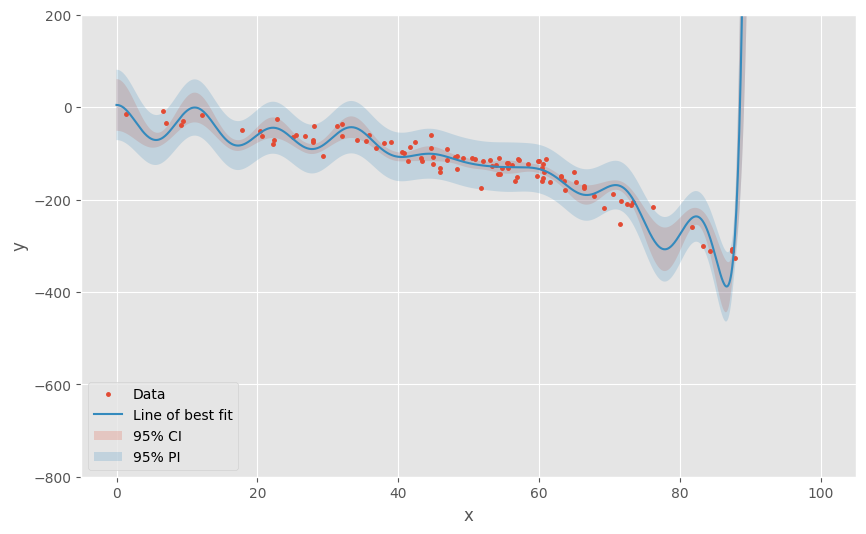

In [28]:
xs = np.linspace(0, 100, 1000)
Xs = np.zeros((len(xs), 10))
for i in range(10):
    Xs[:,i] = np.exp(-(xs - centres[i])**2 / (2 * variances[i]))
ys, ci, pi = lr.predict(Xs, confidence_interval=0.95, prediction_interval=0.95)

fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(x_obs, y_obs, '.', markersize=5, label='Data')
plt.plot(xs, ys, label='Line of best fit')
plt.fill_between(xs.flatten(), ys-ci, ys+ci, alpha=0.2, label=r'95% CI')
plt.fill_between(xs.flatten(), ys-pi, ys+pi, alpha=0.2, label=r'95% PI')
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(-800, 200)
plt.legend()
plt.show()

In [29]:
# Let's try it out on the Boston housing dataset
from sklearn.datasets import load_diabetes

diabetes = load_diabetes()

X = diabetes.data
y = diabetes.target

lr = LinearRegression()
lr.fit(X, y)
lr.summary()

Linear Regression Summary
Number of observations: 442
Number of predictors: 11
Sigma^2: 2939.5018
R^2: 0.5177
Adjusted R^2: 0.5054
F-statistic: 43.0000
p-value: 0.0000
Coefficients
beta_0: 152.1335
t-score: 58.9928
p-value: 0.0000

beta_1: -10.0099
t-score: -0.1673
p-value: 0.8672

beta_2: -239.8156
t-score: -3.9126
p-value: 0.0001

beta_3: 519.8459
t-score: 7.8042
p-value: 0.0000

beta_4: 324.3846
t-score: 4.9526
p-value: 0.0000

beta_5: -792.1756
t-score: -1.8990
p-value: 0.0582

beta_6: 476.7390
t-score: 1.4046
p-value: 0.1609

beta_7: 101.0433
t-score: 0.4749
p-value: 0.6351

beta_8: 177.0632
t-score: 1.0953
p-value: 0.2740

beta_9: 751.2737
t-score: 4.3653
p-value: 0.0000

beta_10: 67.6267
t-score: 1.0237
p-value: 0.3066



C:\Users\matej\AppData\Local\Temp\ipykernel_16844\2010042896.py:40: RuntimeWarning: invalid value encountered in sqrt
  ci = t_crit * s * np.sqrt(X @ self.inverse_design @ X.T)
C:\Users\matej\AppData\Local\Temp\ipykernel_16844\2010042896.py:41: RuntimeWarning: invalid value encountered in sqrt
  pi = t_crit * s * np.sqrt(1 + X @ self.inverse_design @ X.T)


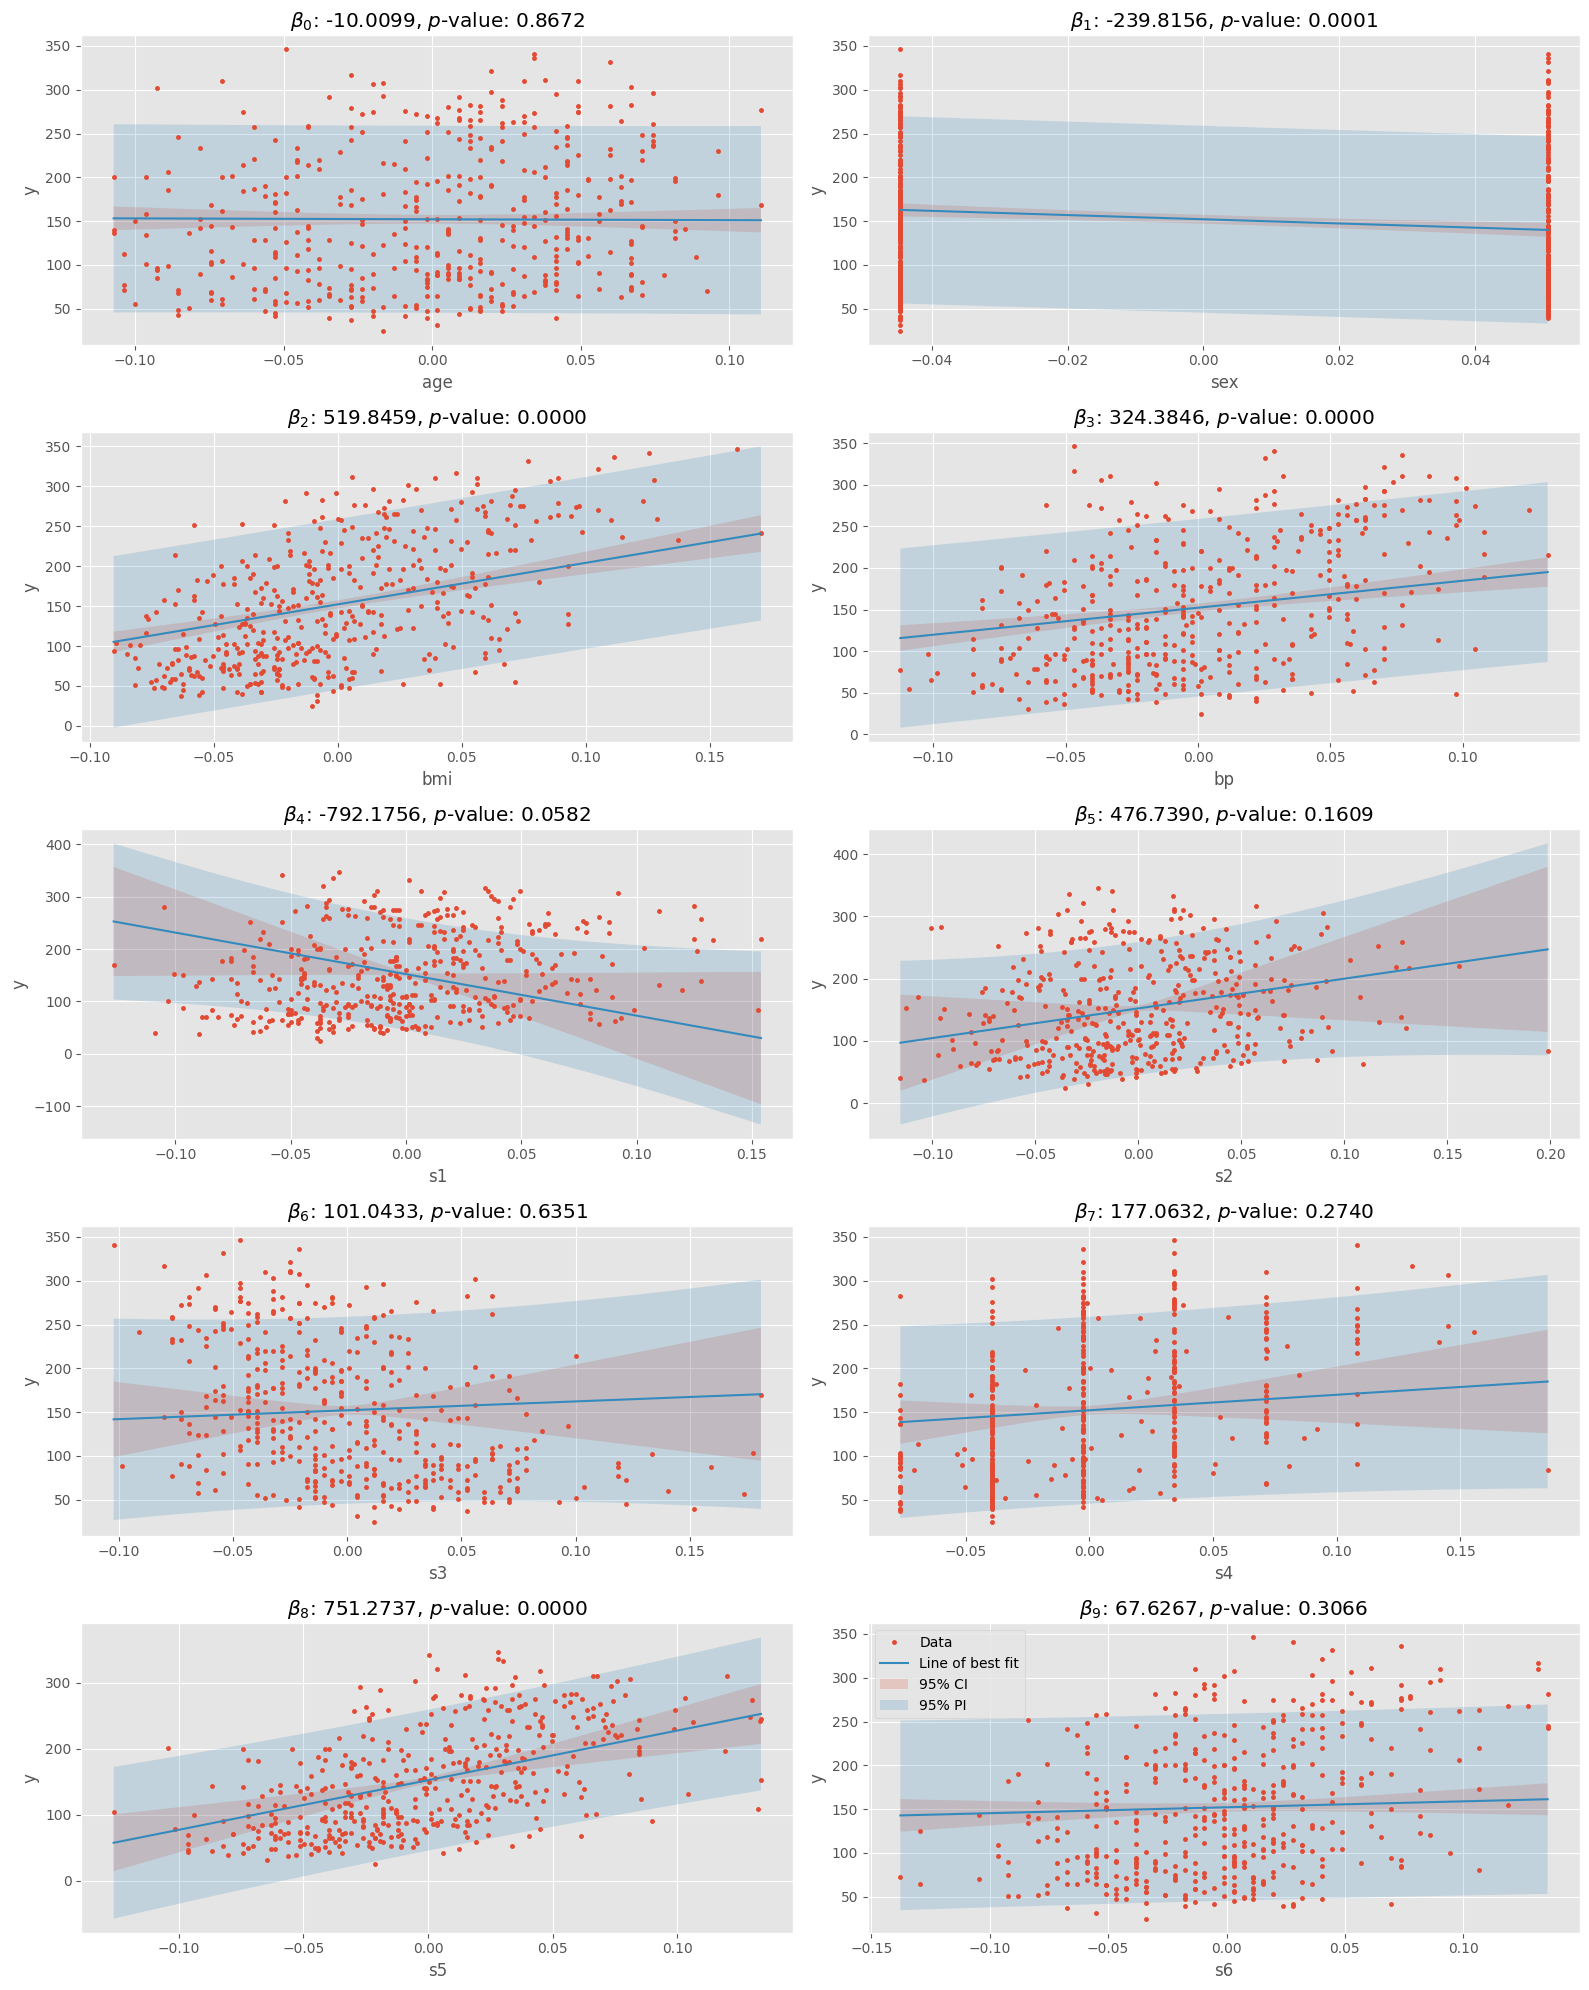

In [30]:
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)

fig, ax = plt.subplots(5, 2, figsize=(16, 20))
ax = ax.flatten()

for i, name in enumerate(diabetes.feature_names):
    xs = np.linspace(X[:,i].min(), X[:,i].max(), 1000)
    # Create an input array with the mean value for all other features
    X_input = np.ones((1000, X.shape[1])) * X_mean
    X_input[:,i] = xs
    
    ys, ci, pi = lr.predict(X_input, confidence_interval=0.95, prediction_interval=0.95)
    
    ax[i].plot(X[:,i], y, '.', markersize=5, label='Data')
    ax[i].plot(xs, ys, label='Line of best fit')
    ax[i].fill_between(xs.flatten(), ys-ci, ys+ci, alpha=0.2, label=r'95% CI')
    ax[i].fill_between(xs.flatten(), ys-pi, ys+pi, alpha=0.2, label=r'95% PI')
    ax[i].set_xlabel(name)
    ax[i].set_ylabel('y')
    ax[i].set_title(rf'$\beta_{i}$: {lr.beta[i+1]:.4f}, $p$-value: {lr.beta_probability[i+1]:.4f}')

plt.legend()
plt.tight_layout()
plt.show()

In [31]:
import statsmodels.api as sm

model = sm.OLS(y, sm.add_constant(X))
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     46.27
Date:                Wed, 28 Jun 2023   Prob (F-statistic):           3.83e-62
Time:                        20:43:27   Log-Likelihood:                -2386.0
No. Observations:                 442   AIC:                             4794.
Df Residuals:                     431   BIC:                             4839.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        152.1335      2.576     59.061      0.000     147.071     157.196
x1           -10.0099     59.749     -0.168      0.867    -127.446     107.426
x2          -239.8156     61.222     -3.917      0.000    -360.147    -119.484
x3           519.8459     66.533      7.813      0.000     389.076     650.616
x4           324.3846     65.422      4.958      0.000     195.799     452.970
x5          -792.1756    416.680     -1.901      0.058   -1611.153      26.802
x6           476.7390    339.030      1.406      0.160    -189.620    1143.098
x7           101.0433    212.531      0.475      0.635    -316.684     518.770
x8           177.0632    161.476      1.097      0.273    -140.315     494.441
x9           751.2737    171.900      4.370      0.000     413.407    1089.140
x10           67.6267     65.984      1.025      0.306     -62.064     197.318
==============================================================================
Omnibus:                        1.506   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.471   Jarque-Bera (JB):                1.404
Skew:                           0.017   Prob(JB):                        0.496
Kurtosis:                       2.726   Cond. No.                         227.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We are going to take $m$ gaussian basis functions. Our model then looks like
$$f(x) = \sum_j w_j \cdot g_j(x; \underline{\mu_j}, \underline{\sigma_j})$$
where $g_j(x; \underline{\mu_j}, \sigma_j)$ is the $j$-th gaussian basis function with mean $\underline{\mu_j}$ and covariance matrix $\underline{\sigma_j^2}$.

The distance calculation looks like
$$\frac{1}{\sqrt{(2\pi)^k |\underline{\sigma_j}|}} \exp \left( -\frac{1}{2} (\underline{x} - \underline{\mu_j})^T \underline{\sigma_j}^{-1} (\underline{x} - \underline{\mu_j}) \right)$$

We can estimate the $\underline{\sigma_j}$ by the sample variance of the data.

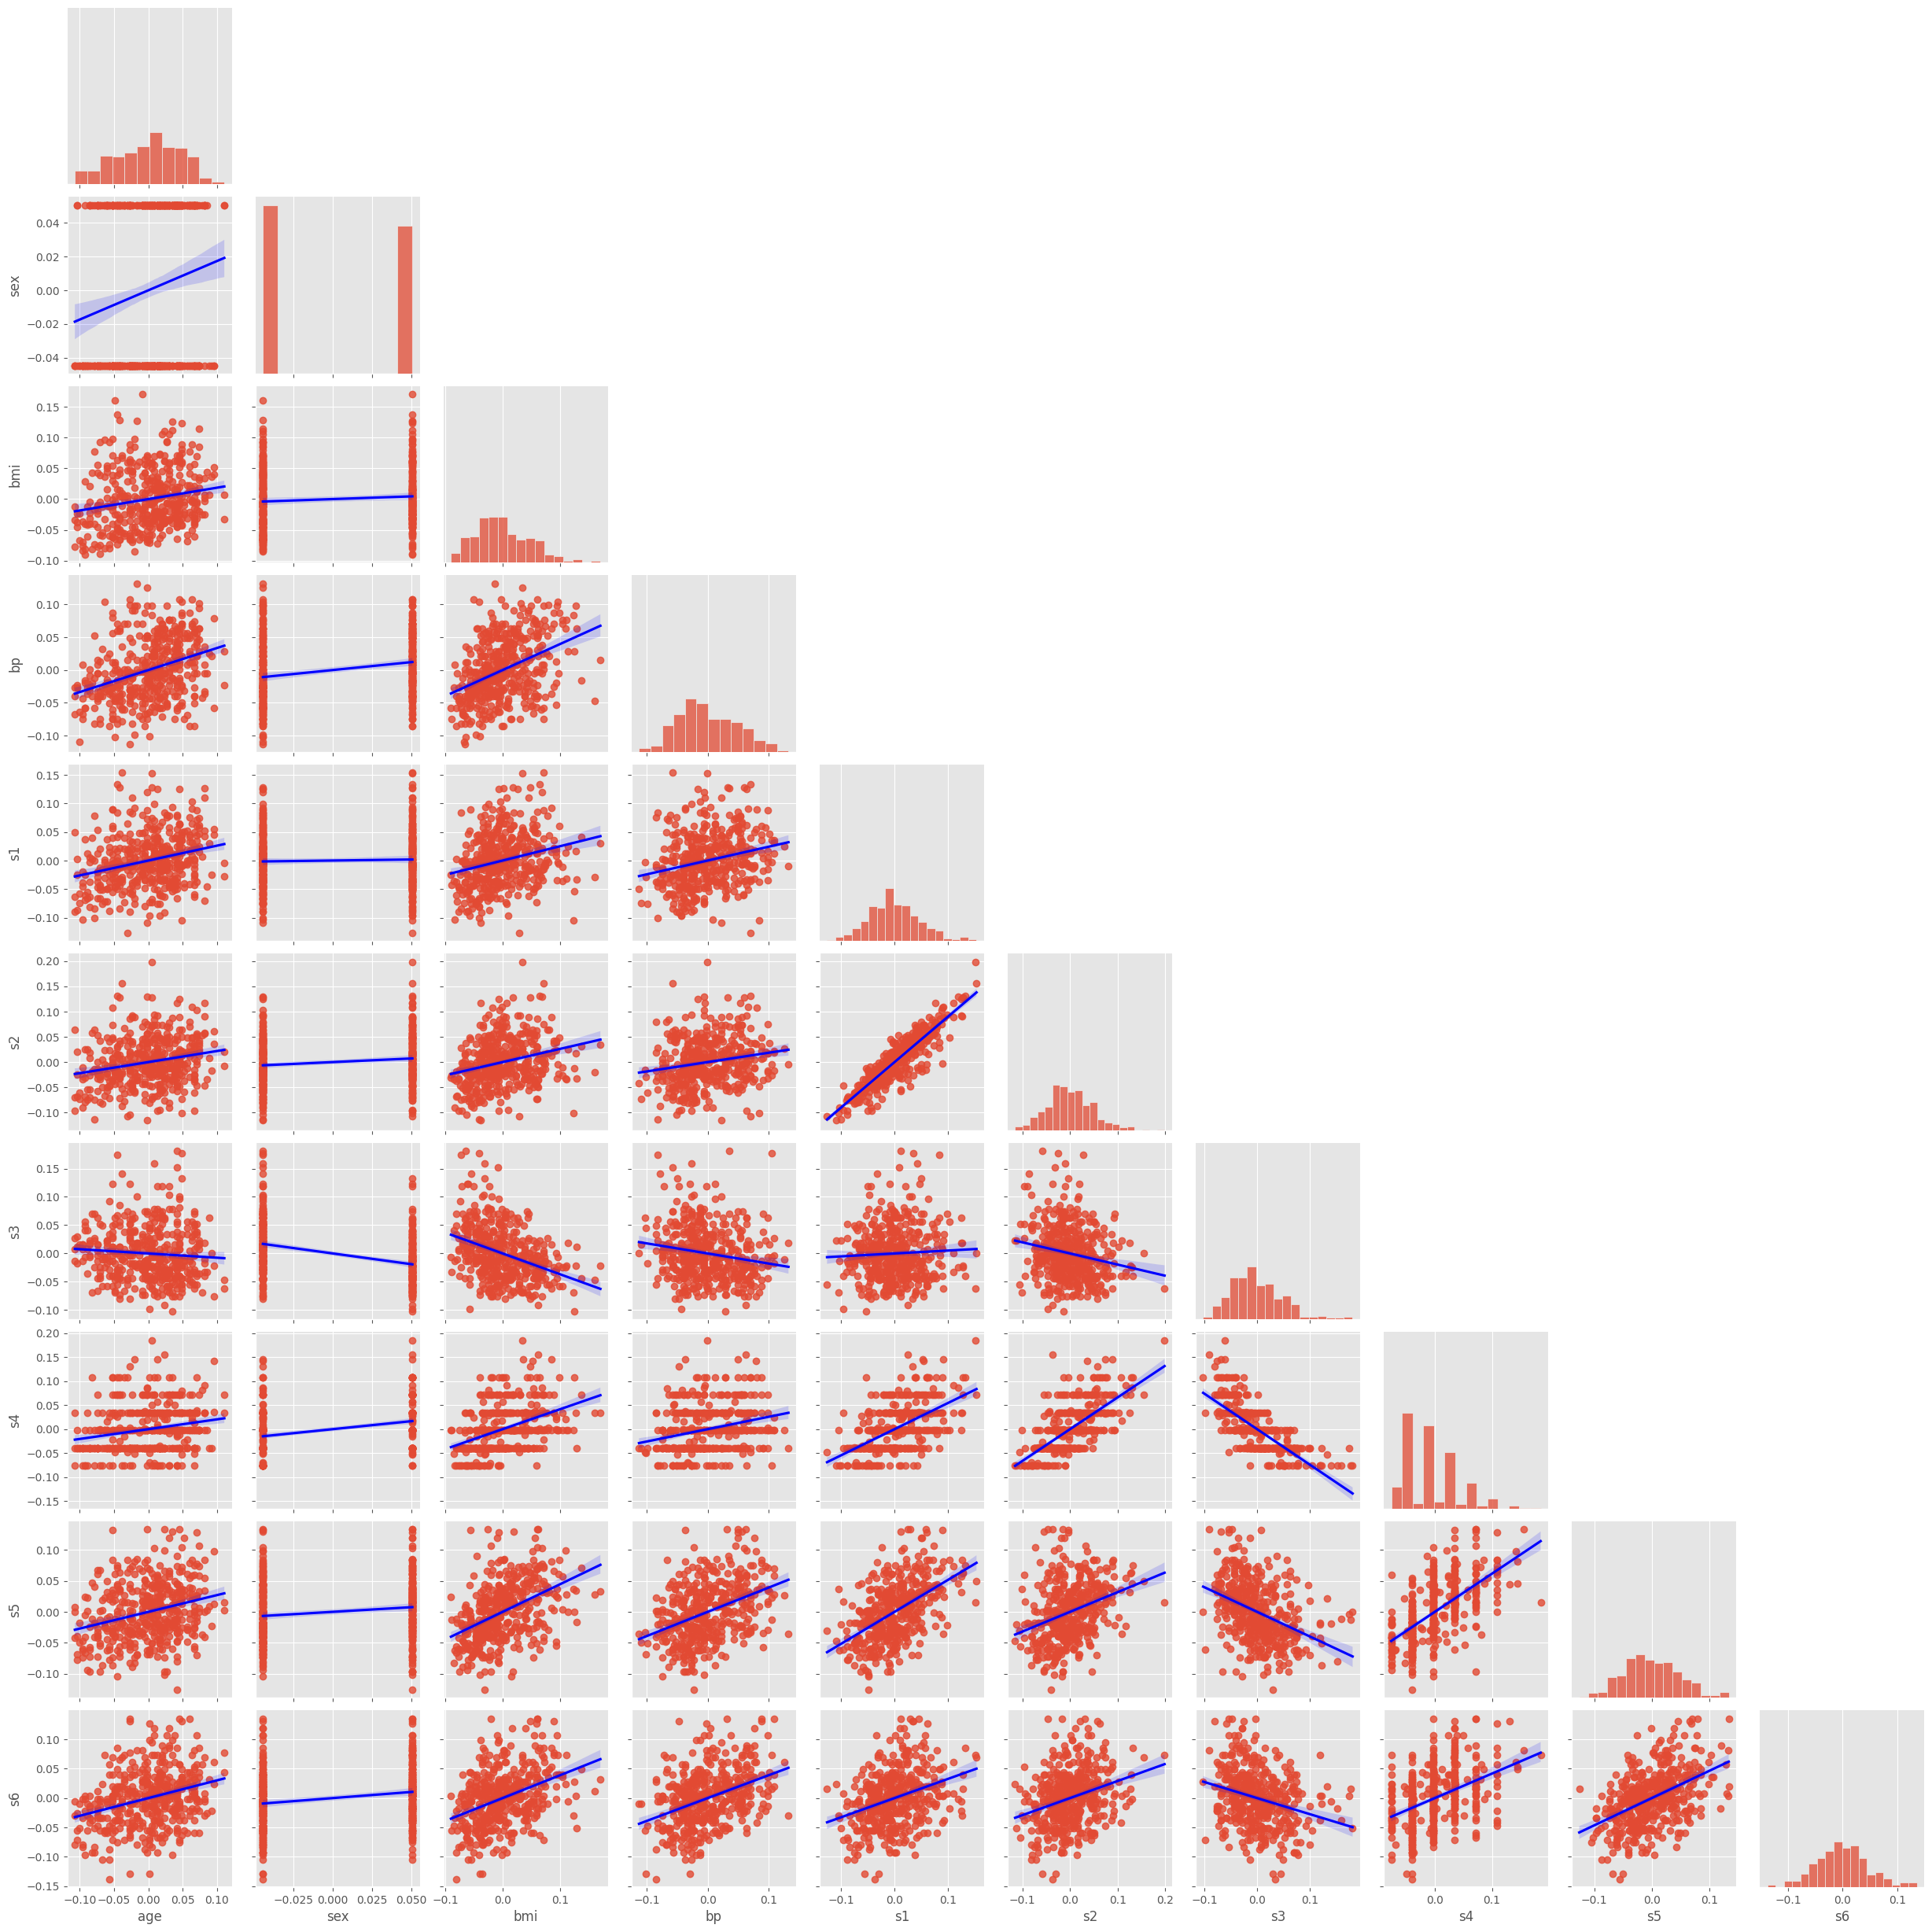

In [32]:
sns.pairplot(pd.DataFrame(X, columns=diabetes.feature_names), kind='reg', corner=True, plot_kws={'line_kws':{'color':'blue'}})
plt.show()

In [48]:
# Estimate the covariance matrix of the parameters
S = np.cov(X, rowvar=False)
S = np.diag(np.diag(S))
S_inv = np.linalg.inv(S)

# Let's do m gaussian basis functions
m = 10
centres = np.zeros((X.shape[1], m))
for i in range(X.shape[1]):
    centres[i] = np.linspace(X[:,i].min(), X[:,i].max(), m)

# Calculate the distances between each data point and each gaussian basis function
X_gauss = np.zeros((X.shape[0], m))
for i in range(X.shape[0]):
    for j in range(m):
        X_gauss[i,j] = np.exp(-1/2*(X[i] - centres[:,j]).T @ S_inv @ (X[i] - centres[:,j]))
    
lr = LinearRegression()
lr.fit(X_gauss, y)
lr.summary()

Linear Regression Summary
Number of observations: 442
Number of predictors: 11
Sigma^2: 5666.8245
R^2: 0.0703
Adjusted R^2: 0.0465
F-statistic: 43.0000
p-value: 0.0000
Coefficients
beta_0: 156.3016
t-score: 33.8328
p-value: 0.0000

beta_1: 202992.4020
t-score: 0.9676
p-value: 0.3338

beta_2: -3062.9009
t-score: -0.9658
p-value: 0.3347

beta_3: -81.6663
t-score: -0.2873
p-value: 0.7740

beta_4: -54.6843
t-score: -0.5365
p-value: 0.5919

beta_5: -352.7889
t-score: -1.8898
p-value: 0.0595

beta_6: 1723.3250
t-score: 2.3409
p-value: 0.0197

beta_7: -14018.5702
t-score: -1.0304
p-value: 0.3034

beta_8: 1742286.8967
t-score: 1.0719
p-value: 0.2843

beta_9: -1342228977.1829
t-score: -0.8590
p-value: 0.3908

beta_10: 7402319528460.9844
t-score: 0.8848
p-value: 0.3767



C:\Users\matej\AppData\Local\Temp\ipykernel_16844\2010042896.py:40: RuntimeWarning: invalid value encountered in sqrt
  ci = t_crit * s * np.sqrt(X @ self.inverse_design @ X.T)


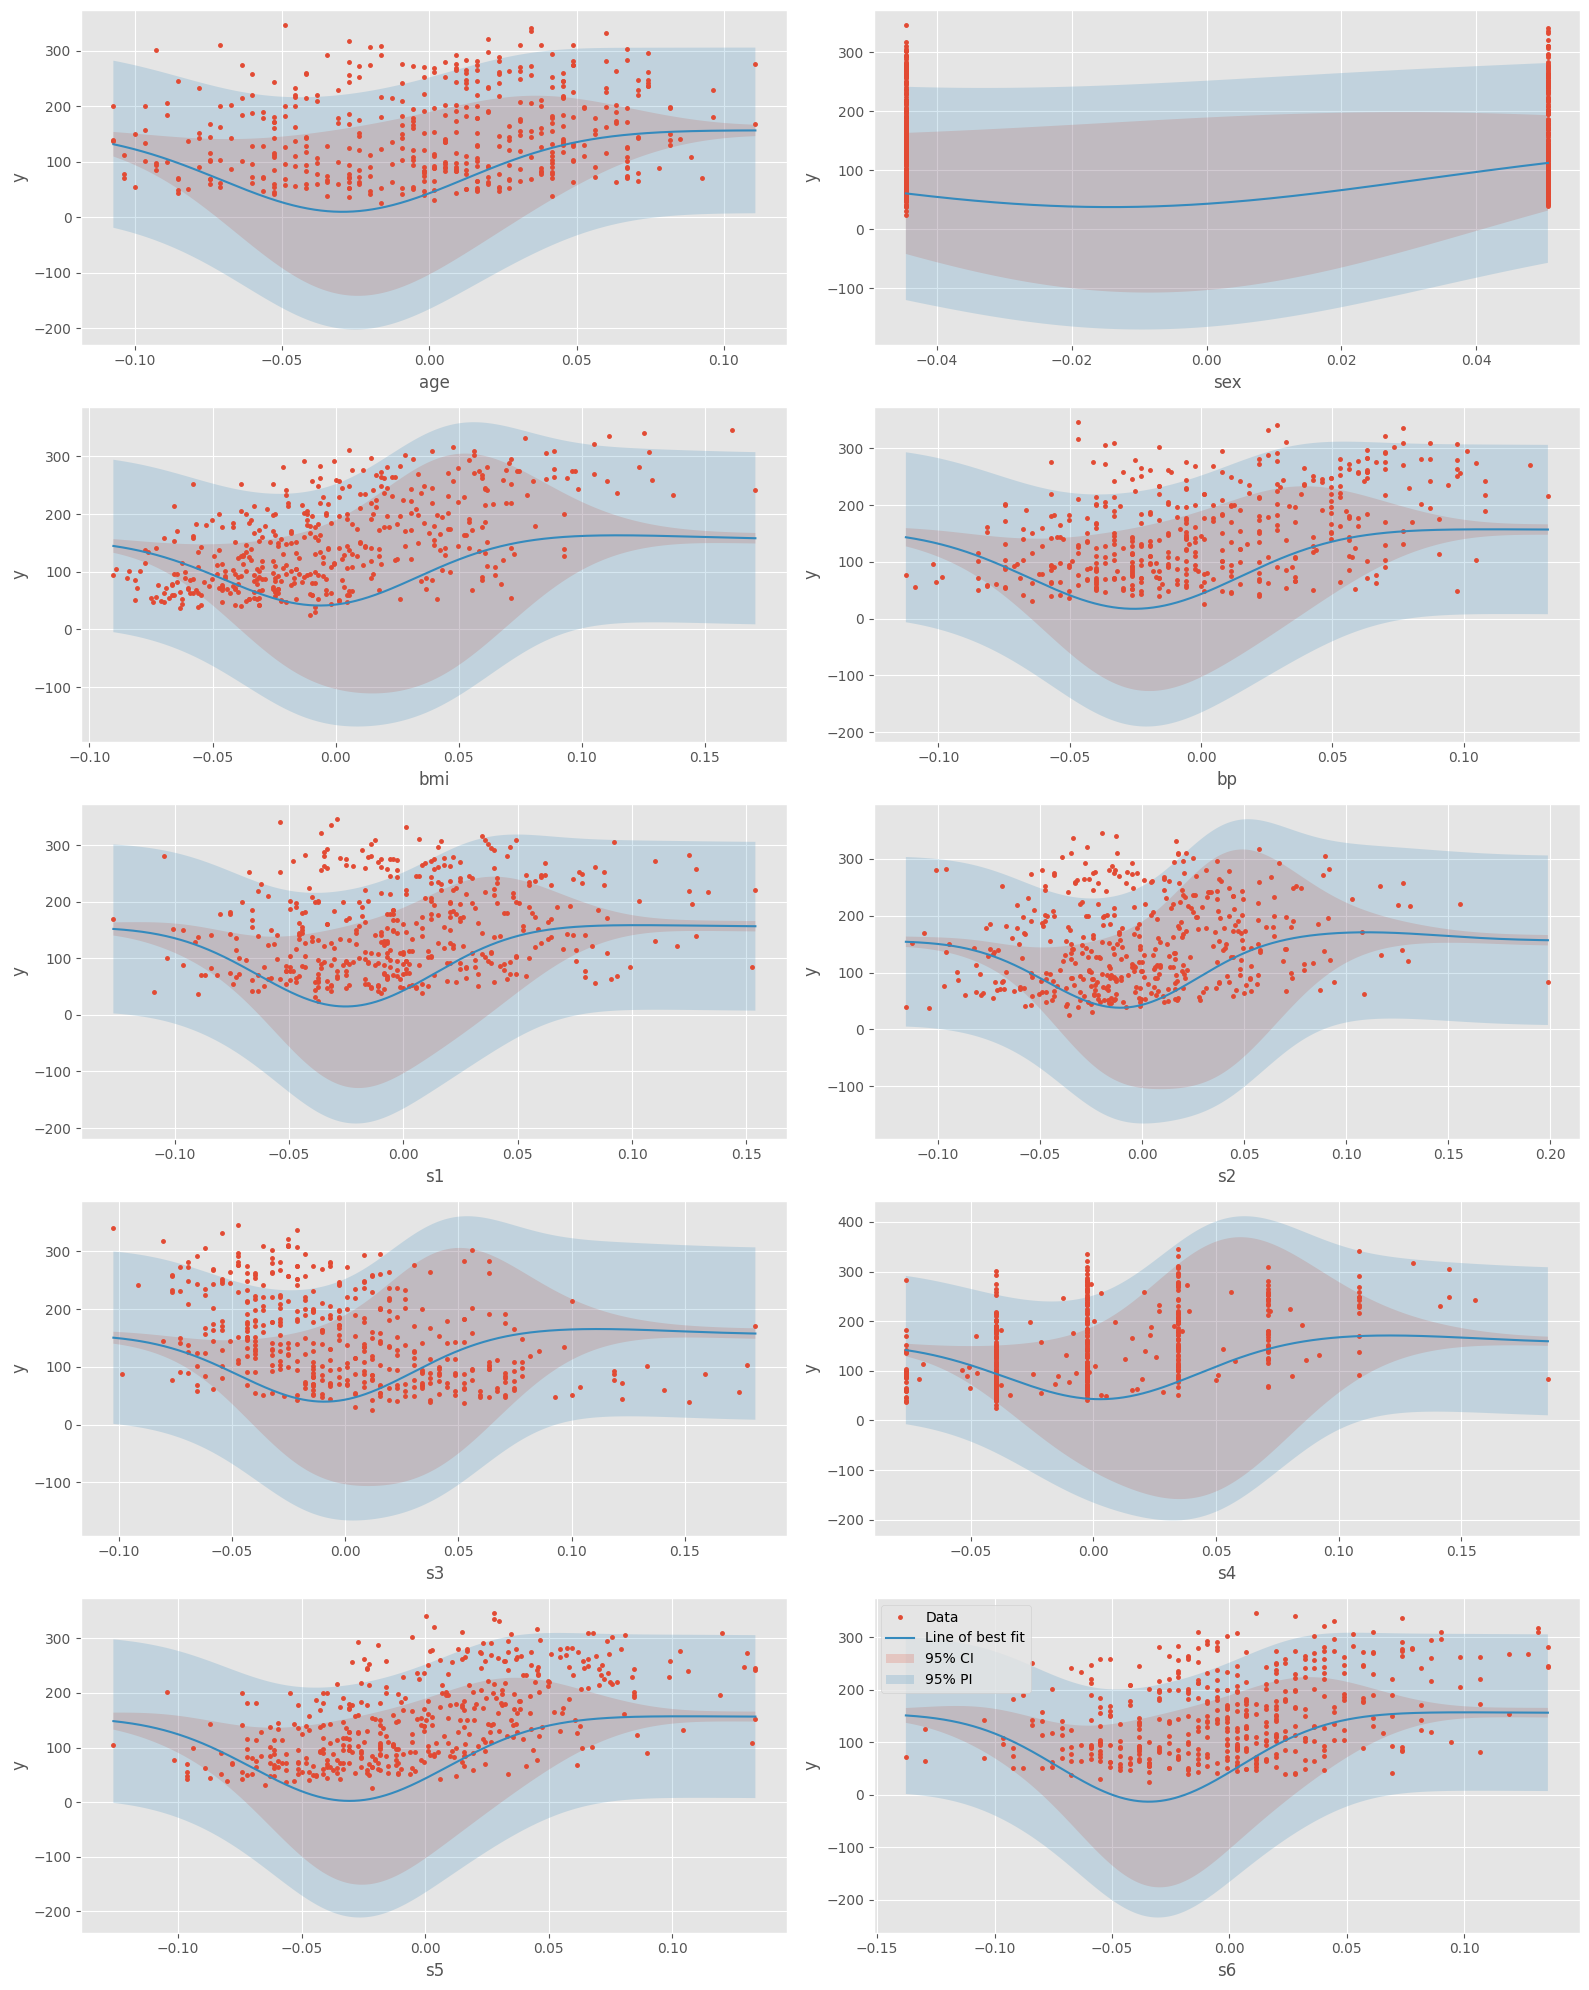

In [46]:
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)

fig, ax = plt.subplots(5, 2, figsize=(16, 20))
ax = ax.flatten()

for i, name in enumerate(diabetes.feature_names):
    xs = np.linspace(X[:,i].min(), X[:,i].max(), 1000)
    # Create an input array with the mean value for all other features
    X_input = np.ones((1000, X.shape[1])) * X_mean
    X_input[:,i] = xs
    # Transform with gaussian basis functions
    X_gauss_input = np.zeros((1000, m))
    for j in range(1000):
        for k in range(m):
            X_gauss_input[j,k] = np.exp(-1/2*(X_input[j] - centres[:,k]).T @ S_inv @ (X_input[j] - centres[:,k]))
    
    ys, ci, pi = lr.predict(X_gauss_input, confidence_interval=0.95, prediction_interval=0.95)
    
    ax[i].plot(X[:,i], y, '.', markersize=5, label='Data')
    ax[i].plot(xs, ys, label='Line of best fit')
    ax[i].fill_between(xs.flatten(), ys-ci, ys+ci, alpha=0.2, label=r'95% CI')
    ax[i].fill_between(xs.flatten(), ys-pi, ys+pi, alpha=0.2, label=r'95% PI')
    ax[i].set_xlabel(name)
    ax[i].set_ylabel('y')

plt.legend()
plt.tight_layout()
plt.show()